# Implementing neural networks

Today, we're going to go through the process together of implementing a neural network for a simple regression problem.  Then I'm going to turn you loose to adapt this methodology to the MNIST problem.

We're going to use a new library to implement this network.  This library is called pytorch, and you can easily install it by following the installation instructions found [here](https://pytorch.org/get-started/locally/).  Why are we not using numpy?  We'll return to that in a moment.  However, torch actually behaves significantly like numpy in a variety of ways.  For example we can generate a synthetic dataset (rather similar to that from Homework 2) using some familiar commands:


In [1]:
import torch
import torch.nn as nn
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

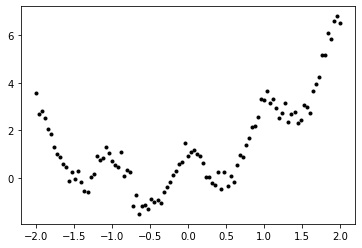

In [2]:
# Generate the features
x = torch.linspace(-2,2,101).reshape(-1,1)

# Generate the response variables 
y_obs = x**2 + x + torch.cos(2*np.pi*x) + torch.randn_like(x)*0.3

plt.plot(x,y_obs,'k.')

We'd like to find a function that fits this data.  One way to do this is, of course, linear regression, but that requires specifying the form of the design matrix.  As we saw in lecture, we'd like to learn the design matrix from the data.  We'll use a neural network to perform this task.  Algebraically, we can specify the neural network via the following sequentially applied functions.
$$
\underbrace{z}_{m\times p} = \underbrace{x}_{m\times 1} \underbrace{W^{(1)}}_{1\times p} + \underbrace{b^{(1)}}_{1\times p}
$$
$$
h = \sigma(z)
$$
$$
\underbrace{y}_{m\times 1} = h \underbrace{W^{(2)}}{p \times 1} + \underbrace{b^{(2)}}_{1\times 1}
$$

Because this is getting a bit complicated, let's develop a create a class for this neural network to hold weights and apply functions as appropriate.    

In [3]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10  # Controls the smoothness
        self.W_2 = torch.randn(p,N)/np.sqrt(p)  # Controls the bounds of the output
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
               
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        
        return self.y


You'll notice that we're instantiating weights randomly.  Let's see what type of functions this model produces, prior to training.  It's interesting to see what the effect is of messing with the variance of the weights when initializing them.   

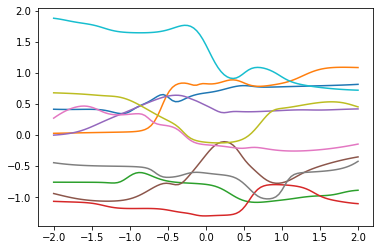

In [4]:
# Sample 10 random neural nets
for i in range(10):
    # Create the neural network
    # n - number of features
    # p - number of hidden layer nodes
    # N - number of outputs
    net = NeuralNet(n=1,p=20,N=1)
    
    # Make a prediction
    y_pred = net.forward(x)
    
    # Plot the predictions
    plt.plot(x,y_pred)


Of course, this isn't all that interesting on its own.  We now need to train this thing.  We'll do this using gradient descent, and herein lies the power of pytorch.  It is a framework for *automatic differentiation*.  What does this mean?  It means that it keeps a record of all of the operations that have been done to produce the output of a given function.  It then can *automaticall* apply the chain rule to produce derivatives of a function with respect to anything that was used to compute it.  Here, we're hoping to take the gradient with respect to the weights and biases.  We can tell pytorch that we're going to want these things by using the "requires_grad_" flag.  

In [2]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)
        self.W_2 = torch.randn(p,N)
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)
        self.b_2 = torch.randn(1,N)
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass
        

One thing that still need is something to minimize.  Since this is a regression problem, we'll use mean-squared-error

In [6]:
def mse(y_pred,y_obs):
    m = y_pred.shape[0]
    return 1./m*((y_pred-y_obs)**2).sum()

Now, the code for gradient descent becomes strikingly simple:

In [7]:
net = NeuralNet(1,20,1)  # Instantiate network
eta = 1e-1               # Set learning rate (empirically derived)
pbar = tqdm.tqdm(position=0)
for t in range(50000):   # run for 50000 epochs
    y_pred = net.forward(x)   # Make a prediction
    L = mse(y_pred,y_obs)     # Compute mse
    net.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in net.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD
    pbar.update(1)
    if t % 2500 == 0:
        pbar.set_description_str(f'Current MSE: {L.item()}')
#     if t%100==0:         # Print loss    
#         print(t,L.item())
    
        


Current MSE: 0.06591946631669998: 49892it [00:16, 3938.07it/s]

Now we can plot our model prediction versus observations.  Pretty good!  And no manual selection of basis functions.

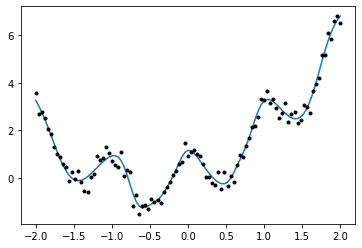

In [8]:
plt.plot(x.detach().squeeze(),y_pred.detach().squeeze())
plt.plot(x.detach().squeeze(),y_obs.detach().squeeze(),'k.')

# Your task:
Train a neural on MNIST using pytorch.  You should use the above code as a template.  Things you'll need to change: $n$ will no longer be 1, but rather 784.  $N$ will no longer be one, but 10.  You'll want to adjust $p$, the number of hidden layer nodes.  You'll likely need to adjust the learning rate.  Finally, and most importantly, you'll need to use a different loss function.  In particular, you'll replace our handrolled MSE code with [this](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).  IMPORTANT NOTE: this loss expects *logits* as inputs, which is to say that it will do softmax for you internally.  As such, the architecture of your network should be more or less the same as above.  

In [3]:
import pickle
mnist = pickle.load(open('mnist.p', 'rb'))

In [18]:
data = mnist.data
#! Perform normalization
norm_data = ((data - data.mean()) / data.std())

#! Convert the labels to a one-hot encoding
encoding = np.zeros([mnist.target.size, 10])

# Loop over each image
for i in range(mnist.target.size):
    encode_vec = np.zeros(10)
    t = int(mnist.target[i])
    encode_vec[t] = 1
    encoding[i] = encode_vec
    
x_tensor = torch.Tensor(norm_data)
y_tensor = torch.Tensor(encoding)

#! Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(x_tensor, y_tensor, test_size=0.25, random_state=42)
# X_train = X_train[0:1000]
# Y_train = Y_train[0:1000]
rows = np.arange(0, X_train.shape[0], 1)
print(rows)
batch = np.random.choice(rows, 100)
print(batch)

[    0     1     2 ... 52497 52498 52499]
[28271  7990 40681 19577 41147 48844 24109 40880 17036 32522 39052 41971
 13766  4337 25409 16280 40473 16019 22900 37926 32083 21051  4054  5145
 45278 24093 34038 26362 18653 11203 29802 25270 42035 27901 39793  7784
  5725 23776 41758 24647 44266 18243 32302 17916  1982 41015 19389 18401
 31067  6367  9113  5519 23434 36672 16586 49842 36199  8005 42749 29205
 12707 10259 30610 23723 13528 19525 25917 47871  4085  4009 29453 45074
 24910 10835 43768 19541 14564 26156 43753 11157 52354 26979 22047 34261
 35979 49674   678 28810 40071 45883 17159 50906   630 48773 35454 11484
 10743 21222 24162 49991]


In [56]:
net = NeuralNet(data.shape[1],20,10)  # Instantiate network
loss = nn.CrossEntropyLoss()
eta = 1e-1  # Set learning rate (empirically derived)
epochs = 500
loss_list = []
for t in tqdm.tqdm(range(epochs), position=0):   # run for 50000 epochs
    batch = np.random.choice(rows, 100)
    x_batch = X_train[batch]
    y_batch = Y_train[batch]
    y_pred = net.forward(x_batch)
    target = y_batch.argmax(-1)
    # y_pred = net.forward(X_train)
    # target = Y_train.argmax(-1)       # Make a prediction
    L = loss(y_pred,target) + torch.sum(net.W_1**2)
    loss_list.append(L.item())
    # Compute mse
    net.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in net.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1453.49it/s]


In [57]:
y_pred = net.forward(X_test)

successes = 0
guess = y_pred.argmax(-1).numpy()
target = Y_test.argmax(-1).numpy()
total = guess.size

for i in range(total):
    if guess[i] == target[i]:
        successes += 1
print(f'Got {successes / total * 100:.2f}% correct')

Got 50.95% correct


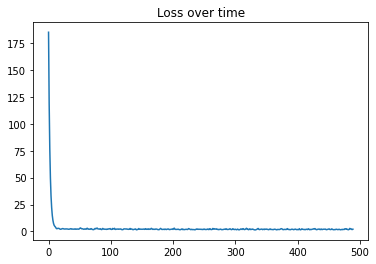

In [64]:
plt.plot(loss_list[10:])
plt.title('Loss over time')
plt.show()

In [59]:
print(net.W_1.shape)

torch.Size([784, 20])


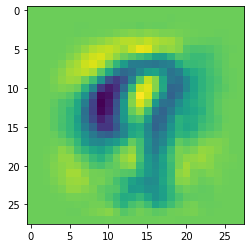

In [62]:
plt.imshow(net.W_1[:, 2].reshape(28, 28).detach())